In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import KFold
from pandas.plotting import scatter_matrix as sm

In [3]:
df = pd.read_csv('garmin_data_clean_level_1_v4.csv')

In [4]:
df.shape

(1616885, 40)

In [5]:
df.isna().sum()

Unnamed: 0                          0
_id                                 0
message_type                        0
message_frame_type                  0
message_global_mesg_num             0
message_local_mesg_num              0
message_name                        0
timestamp                           0
position_lat                        0
position_long                       0
distance                            0
accumulated_power              240115
enhanced_altitude                   0
altitude                            0
enhanced_speed                      0
speed                               0
power                          241561
unknown_88                          0
heart_rate                          0
cadence                             0
temperature                         0
fractional_cadence                  0
record_id                           0
activity_id                         0
unknown_90                     573817
left_pco                       915380
right_pco   

# Addditonal Data Cleanup for Power Analysis

## Change string timestamps into actual timestamps

In [6]:
df['timestamp'] = df['timestamp'].apply(pd.to_datetime)

## Remove power values with poor calibration

In [7]:
df1 = df[['timestamp','distance','activity_id',
         'altitude','speed','power','heart_rate','cadence','temperature', 'left_right_balance']]

In [8]:
df_grouped = df1[['activity_id','speed','power','altitude',
           'heart_rate','cadence','temperature',
           'timestamp', 'left_right_balance']].groupby('activity_id')

In [9]:
df_activity_summary = df_grouped.agg({'speed': "mean",'power': "mean", 'heart_rate': "mean","timestamp": np.min})

In [10]:
df_activity_summary.shape

(493, 4)

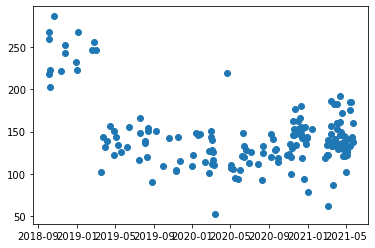

In [11]:
plt.plot_date(df_activity_summary.timestamp, df_activity_summary.power)

In [12]:
# there are some power values that seem to be off.  
# I think this comes from poor calibration of the power meter.  Removing these values
df1 = df1[df1['activity_id'] >=31689725151]

In [13]:
df_grouped = df1[['activity_id','speed','power','altitude',
           'heart_rate','cadence','temperature',
           'timestamp']].groupby('activity_id')

In [14]:
df_activity_summary = df_grouped.agg({'speed': "mean",'power': "mean", 'heart_rate': "mean","timestamp": np.min})

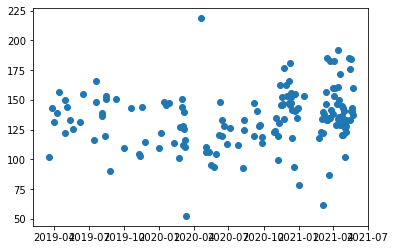

In [15]:
plt.plot_date(df_activity_summary.timestamp, df_activity_summary.power)

## Remove outlier power values

<AxesSubplot:>

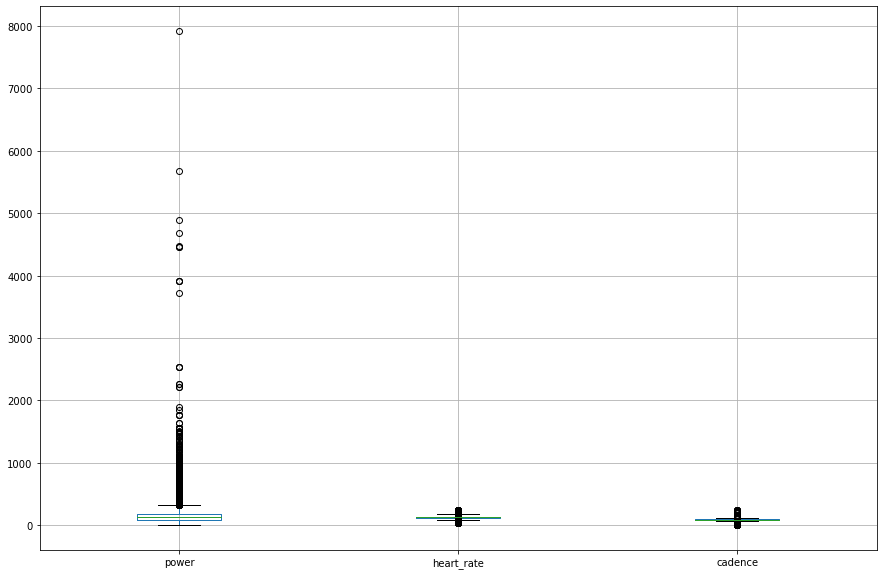

In [16]:
df_outliers = df1[['power', 'heart_rate', 'cadence']]
df_outliers.boxplot(figsize = (15,10))

In [17]:
# 9 standard deviations was choosen because 1000 watts is possible.  
# 8000 watts means I should be enter the Tour de France
df1 = df1[df1.power-df1.power.mean() <= (9*df1.power.std())]

In [18]:
df1.shape

(1253448, 10)

<AxesSubplot:>

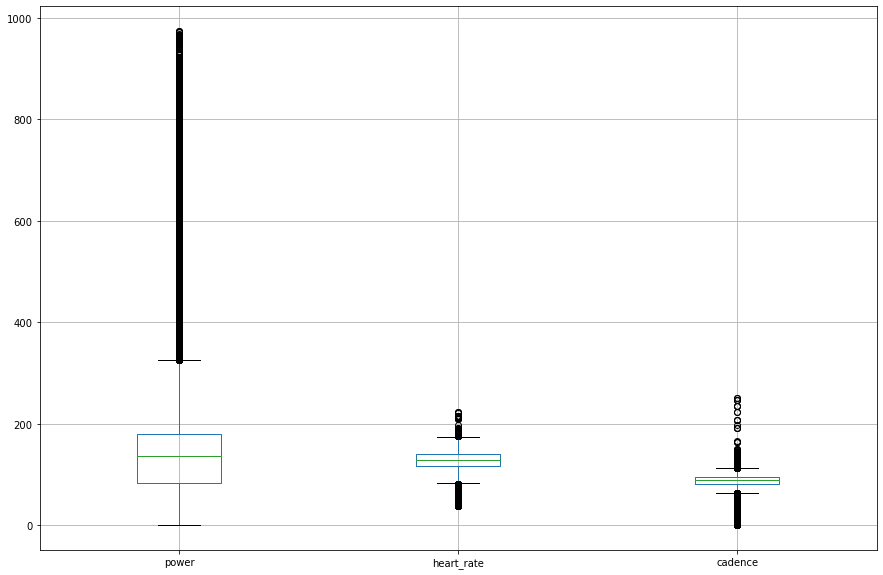

In [19]:
df_outliers = df1[['power', 'heart_rate', 'cadence']]
df_outliers.boxplot(figsize = (15,10))

## Remove heart rate and cadence outliers.  
Very unlikely I can pedal beyond 150 rpm and HR over 200 is unlikely for a person my age

<AxesSubplot:>

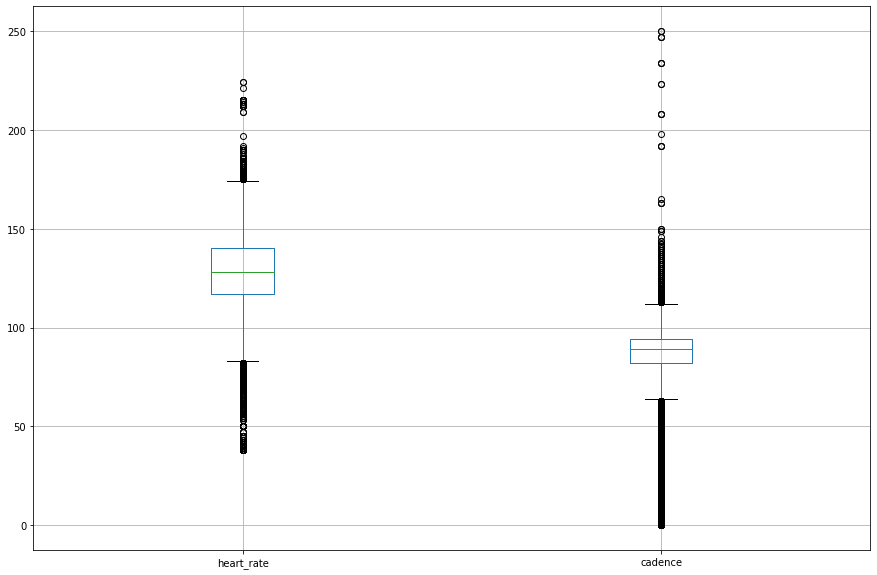

In [20]:
df_outliers = df1[['heart_rate', 'cadence']]
df_outliers.boxplot(figsize = (15,10))

In [21]:
df1 = df1[df1.heart_rate-df1.heart_rate.mean() <= (4*df1.heart_rate.std())]

In [22]:
df1 = df1[df1.cadence-df1.cadence.mean() <= (3*df1.cadence.std())]

In [23]:
df1.shape

(1253408, 10)

<AxesSubplot:>

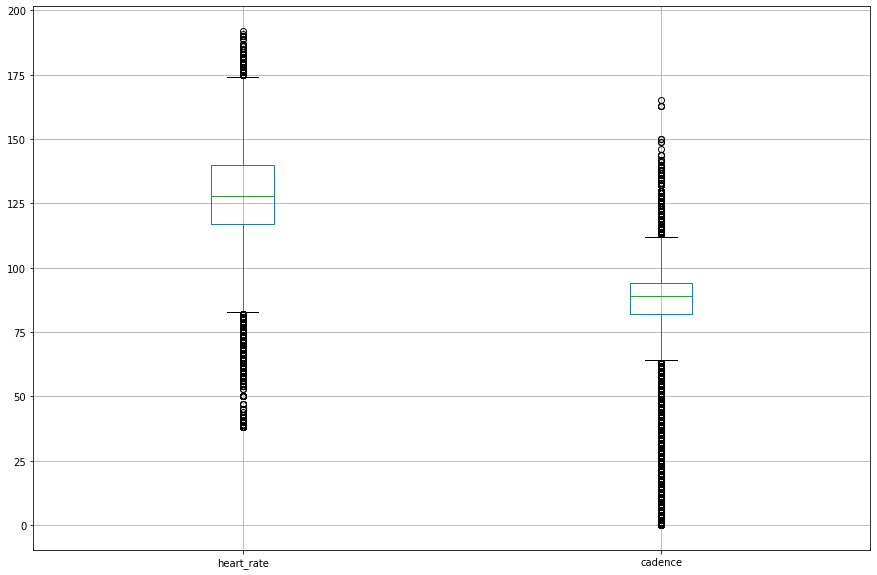

In [24]:
df_outliers = df1[['heart_rate', 'cadence']]
df_outliers.boxplot(figsize = (15,10))

## Unit Conversion 

In [25]:
df1['speed'] = df1['speed'] * 2.237 # m/s to mph

In [26]:
df1['distance'] = df1['distance'] / 1609 # m to miles

In [27]:
df1['temperature'] = df1['temperature'] * 9/5 + 32 # C to F

In [28]:
df1['altitude'] = df1['altitude'] * 3.28084 # meters to feet

# Analyze remaining data

## Create Correlation matrix and explain results

In [29]:
df1.corr()

,distance,activity_id,altitude,speed,power,heart_rate,cadence,temperature,left_right_balance
distance,1.000000,-0.005027,-0.091256,-0.035806,-0.056768,0.041601,-0.024079,0.144919,0.021087
activity_id,-0.005027,1.000000,0.195598,-0.076035,0.061462,-0.335522,0.049262,-0.155302,-0.239628
altitude,-0.091256,0.195598,1.000000,-0.126306,-0.020130,-0.115356,-0.037334,0.005292,0.043095
speed,-0.035806,-0.076035,-0.126306,1.000000,0.165168,0.219364,0.418918,0.032259,-0.050274
power,-0.056768,0.061462,-0.020130,0.165168,1.000000,0.207141,0.508187,-0.053251,-0.029130
heart_rate,0.041601,-0.335522,-0.115356,0.219364,0.207141,1.000000,0.236142,0.084429,0.099166
cadence,-0.024079,0.049262,-0.037334,0.418918,0.508187,0.236142,1.000000,-0.041508,-0.066065
temperature,0.144919,-0.155302,0.005292,0.032259,-0.053251,0.084429,-0.041508,1.000000,0.065683
left_right_balance,0.021087,-0.239628,0.043095,-0.050274,-0.029130,0.099166,-0.066065,0.065683,1.000000


<strong>Power (watts) to distance (miles)</strong>.  Weak negative correlation (-0.05).  This is expected as the it is difficult to continue to produce power as you tire.  Distance is also in meters so the correlation will be weak. This shows how fatigue impacts your ability to produce power. The plot below shows a fairly consistent rate of reduction as distance increases.  

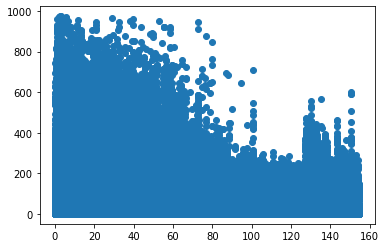

In [30]:
plt.scatter(df1.distance, df1.power)

<strong>Power (watts) to Heart Rate (bpm)</strong> There is not as strong a correlation (0.207) as expected but reviewing the graph explains the result.  At high heart rates it is not possible to produce power.  The graph provides does provide very interesting data as seems to indicate the heart that allows the maximum power production is about 130 with an inverted parabola shape on either side.  130 bpm is right in the middle of the aerobic zone so not surprising that above these heart rates, power starts to drop.  The interesting finding is that a low heart rates it does not seem to be possible to produce power either. If you are going to race your buddy to the next stop sign, best to make sure your heart rate is in the middle or low end of your aerobic zone before you start. 

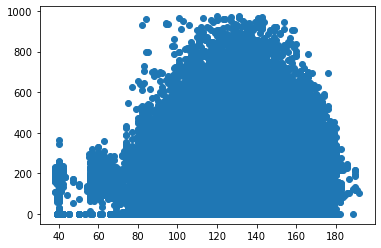

In [31]:
plt.scatter(df1.heart_rate, df1.power)

<strong>Power (watts) to Cadence (rpm) </strong> Cadence is the rate at which your pedals are turning and has a strong correlation to power (0.5).  Power is force times distance. In rotational dynamics, cadence would be distance and tangential force is the force.  Force is limited to your leg strength so as cadence increases the maximum power increases.  This has a limit as well.  Power drops precipitously around 120 rpm. 

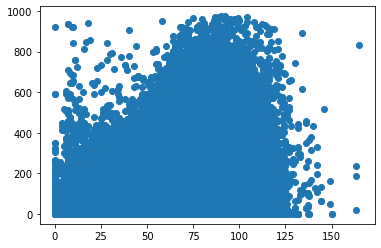

In [32]:
plt.scatter(df1.cadence, df1.power)

<strong> Power (watts) to Temperature (F) </strong> There is a very week negative correlation (0.05) between power and temperature.  Once again the scatter plot seems to indicate a limit. Power drops quickly at about 33 C (91 F) and is about half of max power at 37 C (98 F).

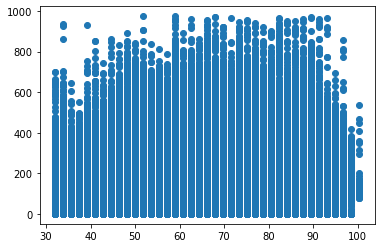

In [33]:
plt.scatter(df1.temperature, df1.power)

<strong> Power (Watts) to Altitude (feet) </strong> - While there is a very weak negative correlation (0.02).  There is not a significant amount of data at higher altititudes and this is not likely a valid representation. 

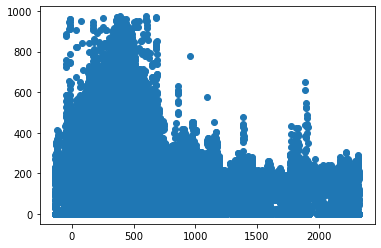

In [34]:
plt.scatter(df1.altitude, df1.power)

<strong> Power (Watts) to Speed (mph) </strong> - There is only a weak correlation (0.165168) between speed and power.  One would expect a much higher correlation but this shows how many other factors such as wind or hills impact speed.  It is also why training is based power or heart rate and not speed for cycling. 

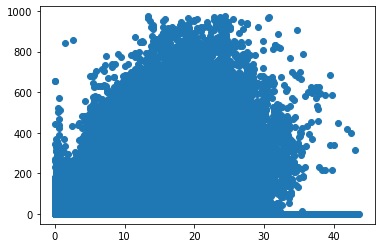

In [35]:
plt.scatter(df1.speed, df1.power)

# Analyze summarized ride data 
This data is grouped by Activity ID and primarily provides average data for each ride. 


In [36]:
df_grouped = df1[['activity_id','speed','power','altitude',
           'heart_rate','cadence','temperature','distance',
           'timestamp', 'left_right_balance']].groupby('activity_id')

In [37]:
df_activity_summary = df_grouped.agg({'speed': "mean",'power': "mean", 'heart_rate': "mean",
                                      "cadence": "mean", "timestamp": np.min, "temperature": "mean",
                                     "altitude": "mean", 'distance':np.max, 'left_right_balance': "mean"})

In [38]:
df_activity_summary.corr()

,speed,power,heart_rate,cadence,temperature,altitude,distance,left_right_balance
speed,1.000000,0.568985,0.456373,0.627713,0.175001,-0.285518,0.128825,-0.006933
power,0.568985,1.000000,0.199312,0.683270,-0.090328,-0.088376,0.019727,-0.167947
heart_rate,0.456373,0.199312,1.000000,0.290720,0.232027,-0.175495,0.084312,0.206560
cadence,0.627713,0.683270,0.290720,1.000000,-0.083128,-0.138868,0.193477,0.005814
temperature,0.175001,-0.090328,0.232027,-0.083128,1.000000,0.030646,0.175279,0.084008
altitude,-0.285518,-0.088376,-0.175495,-0.138868,0.030646,1.000000,-0.015259,0.109831
distance,0.128825,0.019727,0.084312,0.193477,0.175279,-0.015259,1.000000,0.067023
left_right_balance,-0.006933,-0.167947,0.206560,0.005814,0.084008,0.109831,0.067023,1.000000


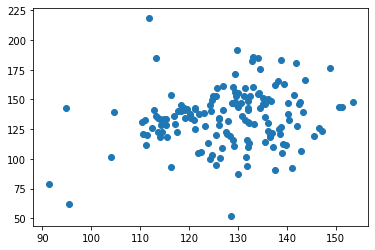

In [39]:
plt.scatter(df_activity_summary.heart_rate, df_activity_summary.power)

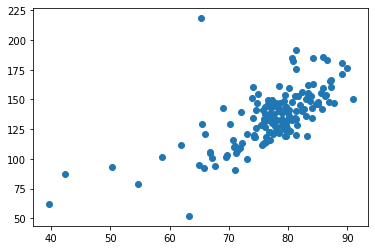

In [40]:
plt.scatter(df_activity_summary.cadence, df_activity_summary.power)

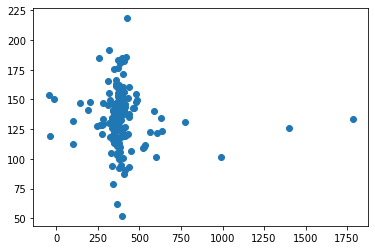

In [41]:
plt.scatter(df_activity_summary.altitude, df_activity_summary.power)

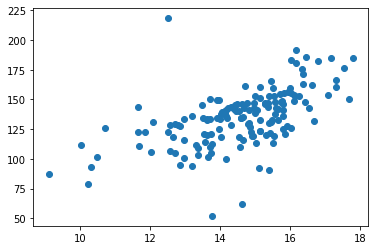

In [42]:
plt.scatter(df_activity_summary.speed, df_activity_summary.power)

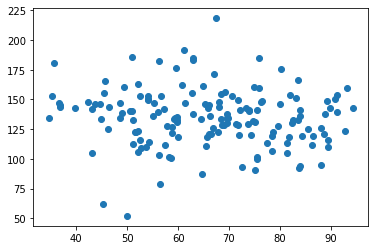

In [43]:
plt.scatter(df_activity_summary.temperature, df_activity_summary.power)

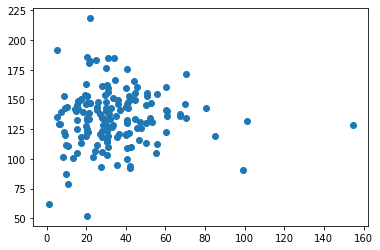

In [44]:
plt.scatter(df_activity_summary.distance, df_activity_summary.power)

In [45]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
from sklearn.linear_model import LinearRegression

<ipython-input-46-e5336037e295>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_activity_summary.hist(ax=ax,bins=15)


array([[<AxesSubplot:title={'center':'speed'}>,
        <AxesSubplot:title={'center':'power'}>,
        <AxesSubplot:title={'center':'heart_rate'}>],
       [<AxesSubplot:title={'center':'cadence'}>,
        <AxesSubplot:title={'center':'timestamp'}>,
        <AxesSubplot:title={'center':'temperature'}>],
       [<AxesSubplot:title={'center':'altitude'}>,
        <AxesSubplot:title={'center':'distance'}>,
        <AxesSubplot:title={'center':'left_right_balance'}>]],
      dtype=object)

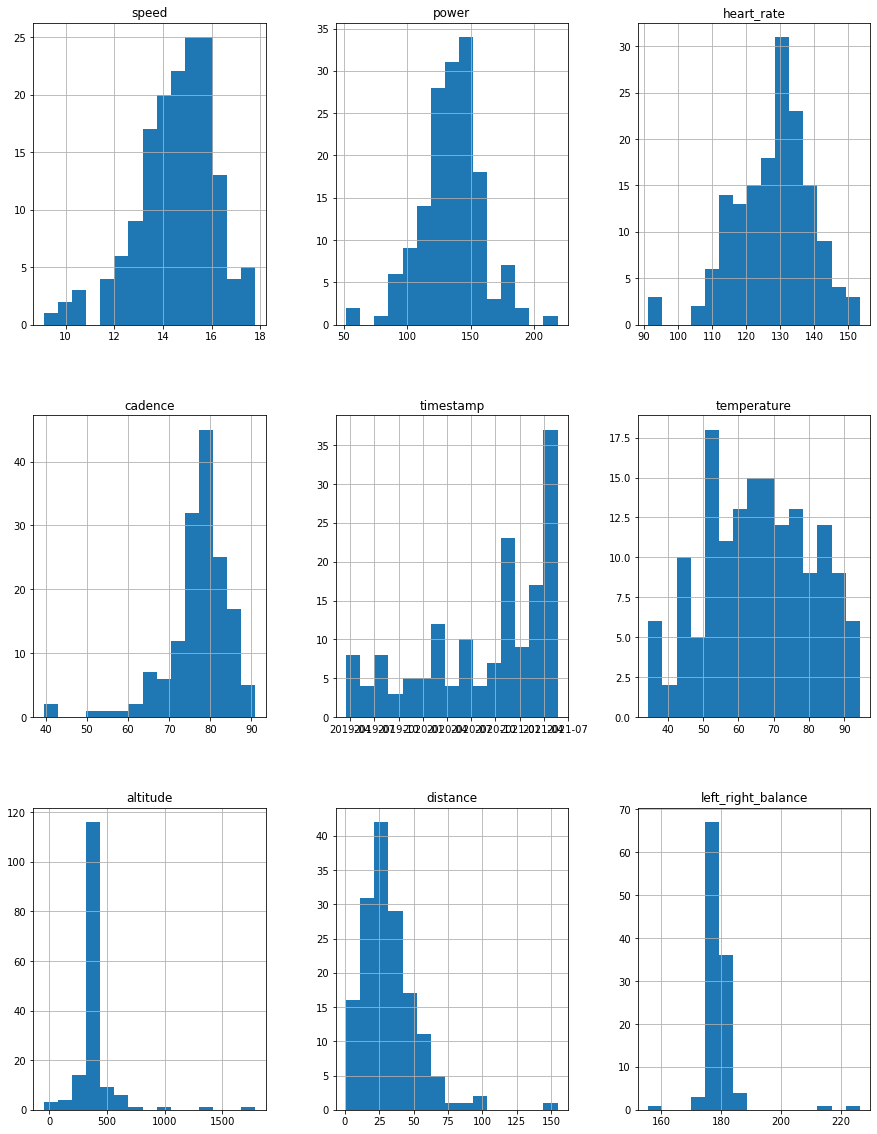

In [46]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_activity_summary.hist(ax=ax,bins=15)


In [47]:
X = pd.DataFrame(df_activity_summary[['temperature','heart_rate', 'altitude','cadence', 'distance']])
y = pd.DataFrame(df_activity_summary['power'])
model = LinearRegression()
scores = []
kfold = KFold(n_splits=4, shuffle=True, random_state=10)
for i, (train, test) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[train,:], y.iloc[train,:])
 score = model.score(X.iloc[test,:], y.iloc[test,:])
 scores.append(score)
print(scores)

[0.46194576570759416, 0.2580564884976996, 0.5369905211499899, 0.5879625193107121]


# Time slice the data into 5 minute intervals to see if this is more meaninful

In [48]:
df2 = df1
df2=df2.set_index('timestamp')

In [49]:
df2.index = df2.index.floor('5T')


In [50]:
df2

,distance,activity_id,altitude,speed,power,heart_rate,cadence,temperature,left_right_balance
timestamp,,,,,,,,,
2021-04-02 16:10:00+00:00,0.002244,87508706738,368.766416,8.077807,54.0,88.0,77.0,55.4,NaN
2021-04-02 16:10:00+00:00,0.005382,87508706738,368.766416,8.453623,78.0,88.0,80.0,55.4,NaN
2021-04-02 16:10:00+00:00,0.006955,87508706738,368.766416,8.516259,80.0,89.0,82.0,55.4,NaN
2021-04-02 16:10:00+00:00,0.009385,87508706738,370.078752,8.746670,80.0,89.0,82.0,55.4,NaN
2021-04-02 16:10:00+00:00,0.011852,87508706738,369.422584,8.892075,80.0,89.0,82.0,55.4,NaN
...,...,...,...,...,...,...,...,...,...
2020-11-18 01:05:00+00:00,20.091759,73304594919,311.679800,5.614870,0.0,111.0,96.0,41.0,154.0
2020-11-18 01:05:00+00:00,20.093319,73304594919,311.679800,5.614870,0.0,111.0,96.0,41.0,154.0
2020-11-18 01:05:00+00:00,20.093319,73304594919,311.679800,0.000000,0.0,110.0,0.0,41.0,NaN


In [51]:
df_timeslice = df2.groupby('timestamp')

In [52]:
df_activity_summary_sliced = df_timeslice.agg({'speed': "mean",'power': "mean", 'heart_rate': "mean",
                                      "cadence": "mean", "temperature": "mean",
                                     "altitude": "mean", 'distance':np.max})

In [53]:
df_activity_summary_sliced.shape

(4644, 7)

In [54]:
df_activity_summary_sliced.corr()

,speed,power,heart_rate,cadence,temperature,altitude,distance
speed,1.000000,0.507630,0.401313,0.617263,0.035340,-0.196146,-0.043210
power,0.507630,1.000000,0.408524,0.731397,-0.130689,-0.040746,-0.127463
heart_rate,0.401313,0.408524,1.000000,0.331009,0.087486,-0.136139,0.084226
cadence,0.617263,0.731397,0.331009,1.000000,-0.100885,-0.086030,-0.052798
temperature,0.035340,-0.130689,0.087486,-0.100885,1.000000,0.007897,0.138896
altitude,-0.196146,-0.040746,-0.136139,-0.086030,0.007897,1.000000,-0.087352
distance,-0.043210,-0.127463,0.084226,-0.052798,0.138896,-0.087352,1.000000


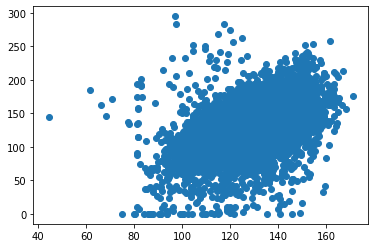

In [55]:

plt.scatter(df_activity_summary_sliced.heart_rate, df_activity_summary_sliced.power)

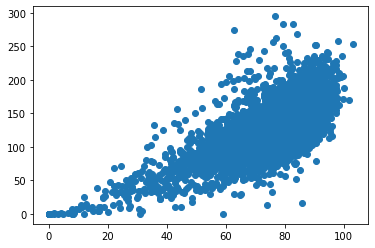

In [56]:
plt.scatter(df_activity_summary_sliced.cadence, df_activity_summary_sliced.power)

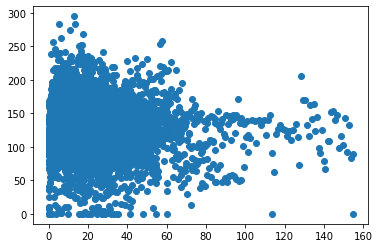

In [57]:
plt.scatter(df_activity_summary_sliced.distance, df_activity_summary_sliced.power)

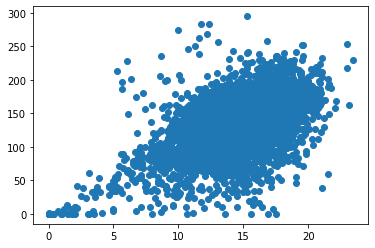

In [58]:
plt.scatter(df_activity_summary_sliced.speed, df_activity_summary_sliced.power)

In [59]:
df1.shape

(1253408, 10)

In [60]:
df_activity_summary.shape

(156, 9)

In [61]:
X = pd.DataFrame(df_activity_summary_sliced[['temperature','heart_rate', 'altitude','cadence', 'distance']])
y = pd.DataFrame(df_activity_summary_sliced['power'])
model = LinearRegression()
scores = []
kfold = KFold(n_splits=4, shuffle=True, random_state=10)
for i, (train, test) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[train,:], y.iloc[train,:])
 score = model.score(X.iloc[test,:], y.iloc[test,:])
 scores.append(score)
print(scores)

[0.5947186529741061, 0.5812909421698036, 0.5810902912161505, 0.5680771270596428]


In [62]:
df.shape


(1616885, 40)

## Create Correlation Heat map

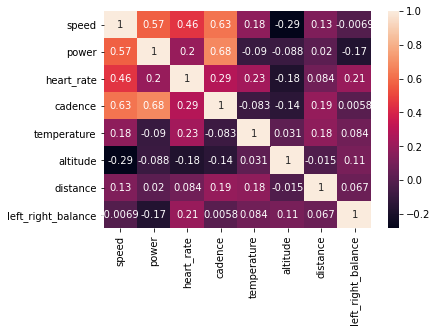

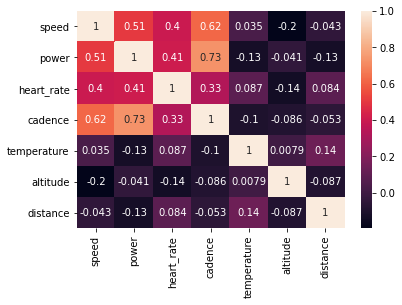

In [63]:
corrMatrix = df_activity_summary.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

corrMatrix1 = df_activity_summary_sliced.corr()
sn.heatmap(corrMatrix1, annot=True)
plt.show()

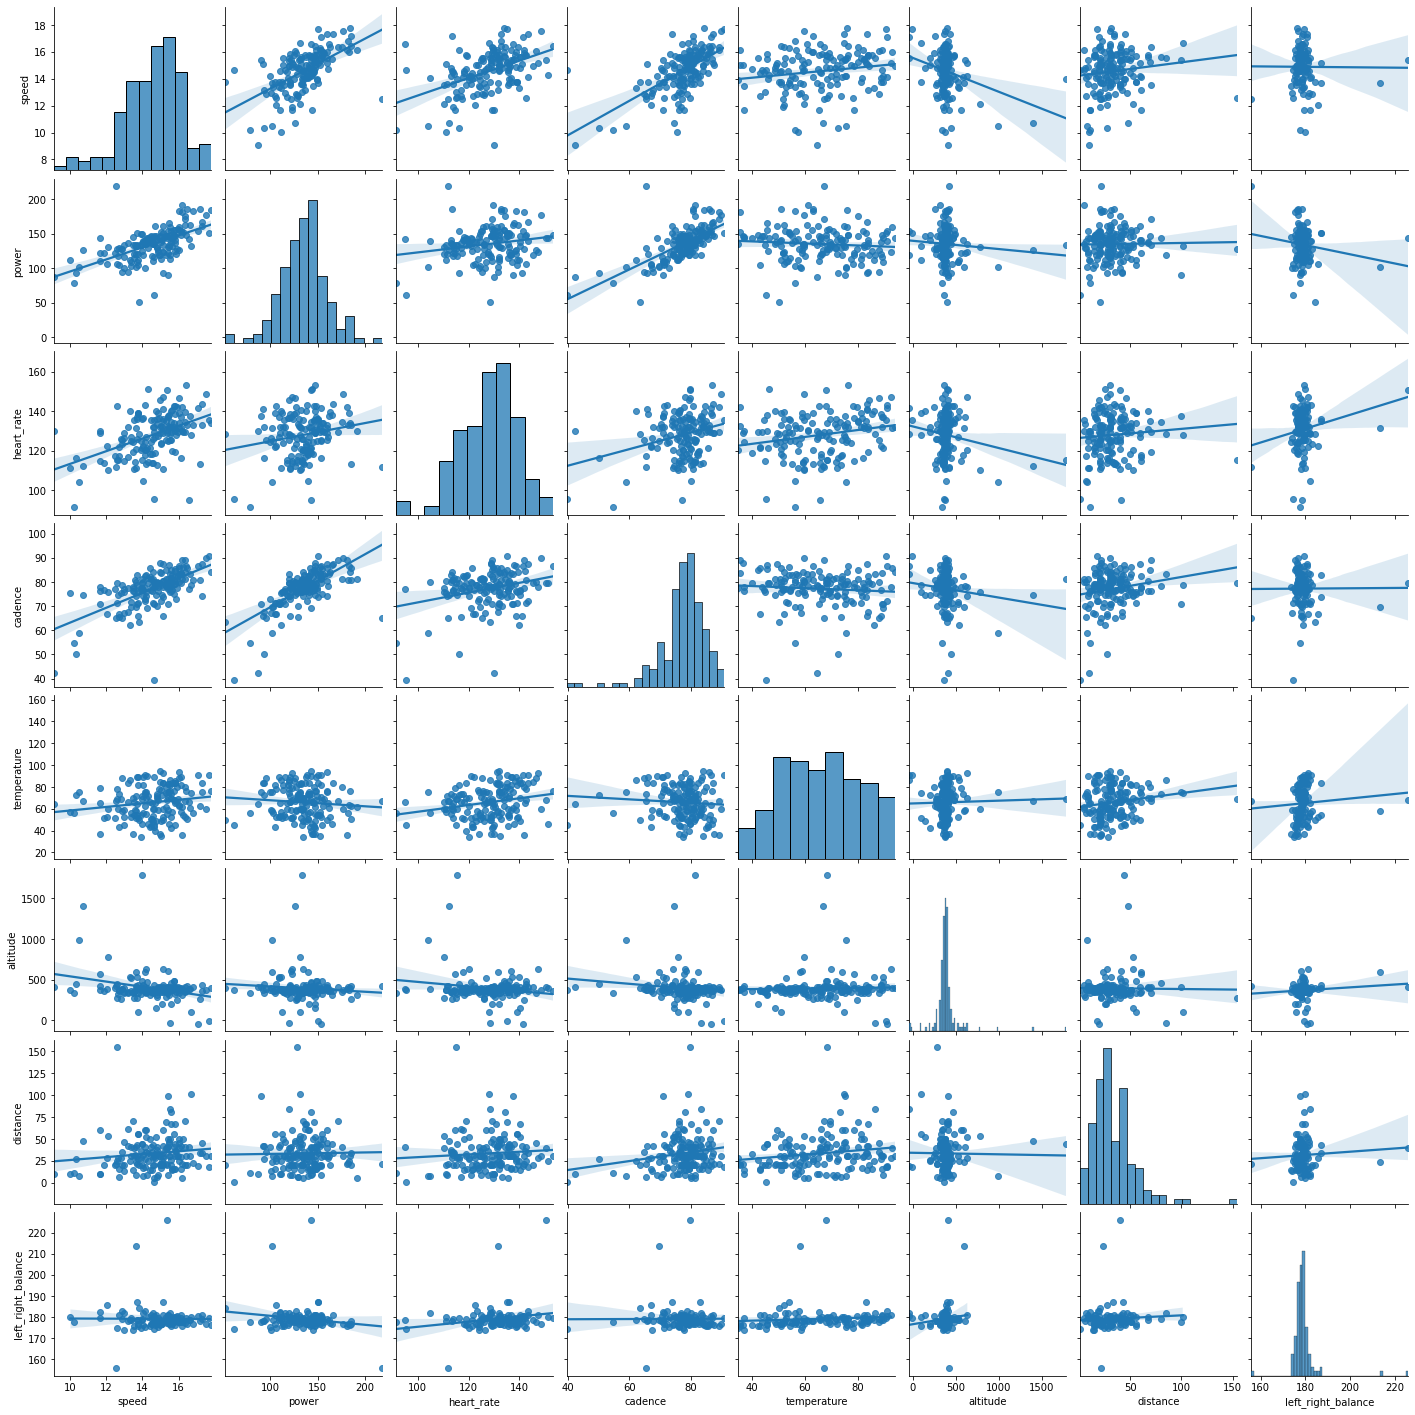

In [64]:
axes = sn.pairplot(df_activity_summary, kind="reg")

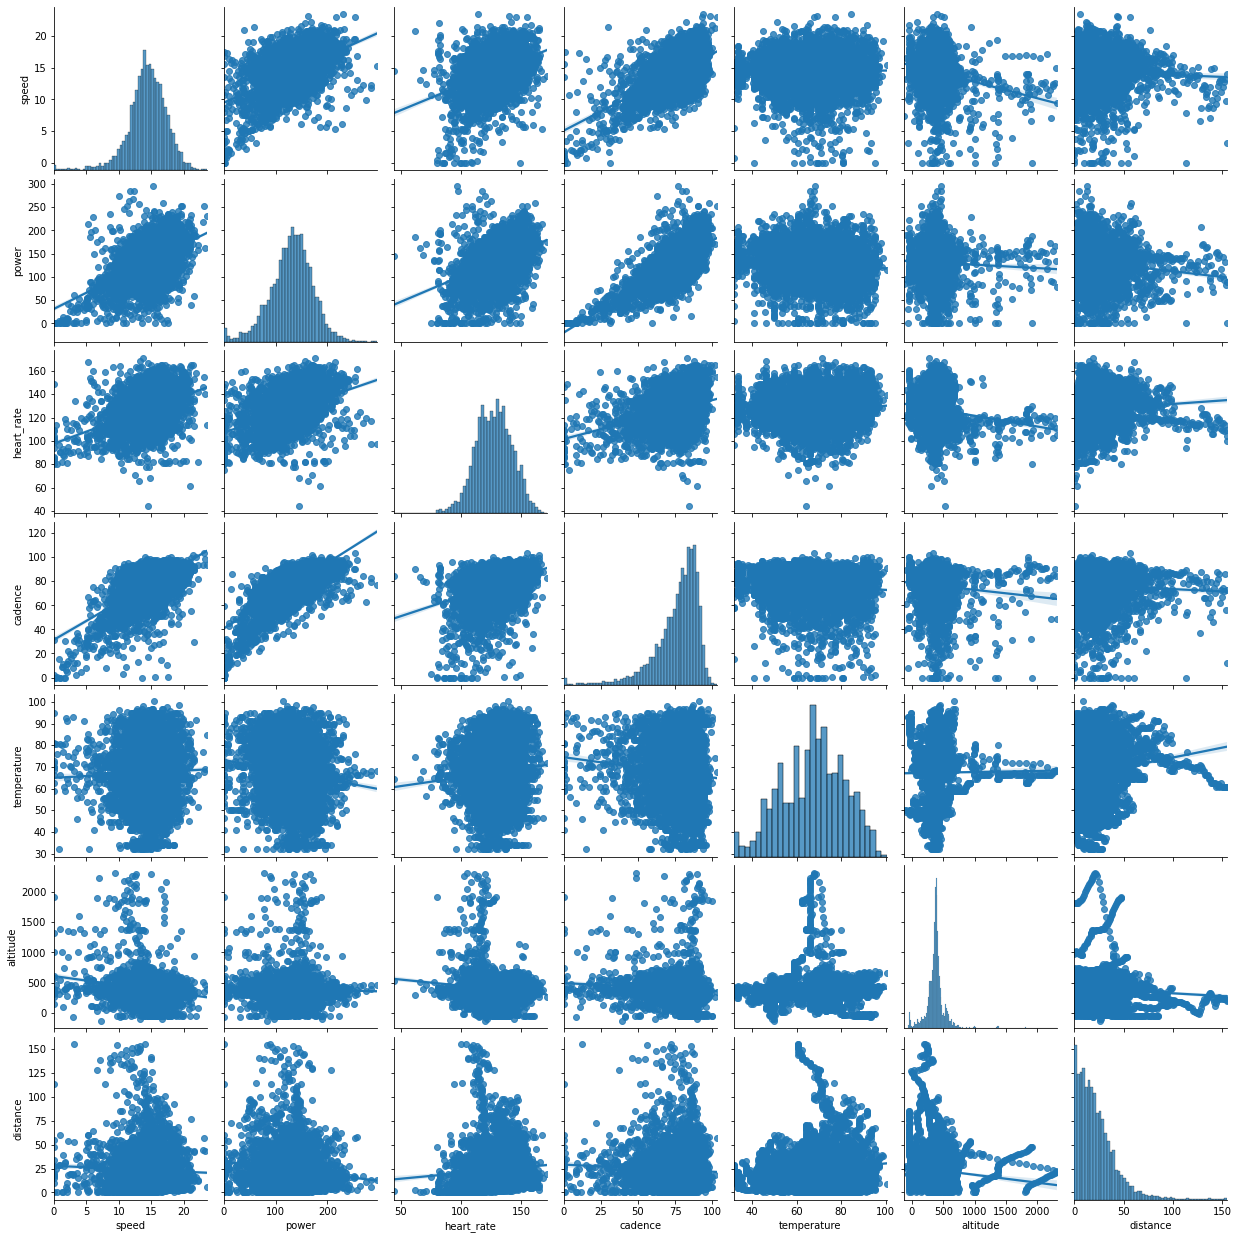

In [65]:
axes1 = sn.pairplot(df_activity_summary_sliced, kind="reg")